In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import pandas as pd
import numpy as np

columns = (
    ['engine_id', 'cycle'] +
    [f'op_{i}' for i in range(1, 4)] +
    [f'sensor_{i}' for i in range(1, 22)]
)

train_df = pd.read_csv(
    '/content/train_FD001.txt',
    delim_whitespace=True,
    header=None,
    names=columns
)

train_df.head()


/tmp/ipython-input-3985645271.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_df = pd.read_csv(


,engine_id,cycle,op_1,op_2,op_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [5]:
print("Shape:", train_df.shape)
print("Engines:", train_df.engine_id.nunique())


Shape: (20631, 26)
Engines: 100


In [6]:
train_df[['engine_id','cycle']].tail()

,engine_id,cycle
20626,100,196
20627,100,197
20628,100,198
20629,100,199
20630,100,200


In [7]:
max_cycle = train_df.groupby('engine_id')['cycle'].max()
train_df['RUL'] = train_df['engine_id'].map(max_cycle) - train_df['cycle']


In [8]:
train_df.groupby('engine_id')['RUL'].agg(['min','max']).head()


,min,max
engine_id,,
1,0,191
2,0,286
3,0,178
4,0,188
5,0,268


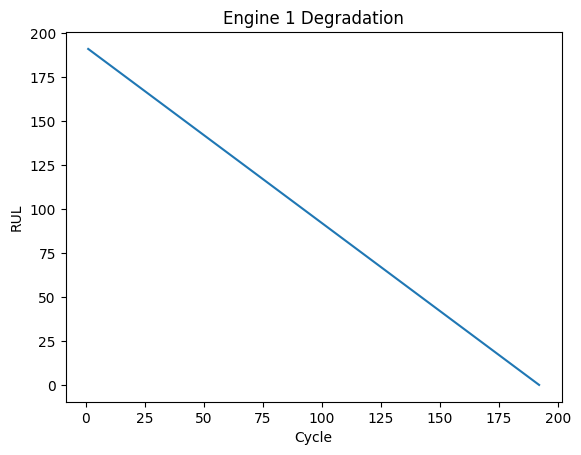

In [9]:
import matplotlib.pyplot as plt

e1 = train_df[train_df.engine_id == 1]

plt.figure()
plt.plot(e1['cycle'], e1['RUL'])
plt.xlabel("Cycle")
plt.ylabel("RUL")
plt.title("Engine 1 Degradation")
plt.show()


In [10]:
train_df.drop(columns=['op_1','op_2','op_3'], inplace=True)


In [11]:
features = [
    'sensor_2','sensor_3','sensor_4','sensor_7',
    'sensor_8','sensor_9','sensor_11','sensor_12',
    'sensor_13','sensor_14','sensor_15',
    'sensor_17','sensor_20','sensor_21'
]


In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_df[features] = scaler.fit_transform(train_df[features])


In [13]:
def create_sequences(df, seq_len, feature_cols):
    X, y = [], []

    for eid in df.engine_id.unique():
        edf = df[df.engine_id == eid].reset_index(drop=True)

        for i in range(len(edf) - seq_len):
            X.append(edf.loc[i:i+seq_len-1, feature_cols].values)
            y.append(edf.loc[i+seq_len, 'RUL'])

    return np.array(X), np.array(y)


In [14]:
SEQ_LEN = 30
X_train, y_train = create_sequences(train_df, SEQ_LEN, features)

print(X_train.shape)
print(y_train.shape)

(17631, 30, 14)
(17631,)


In [15]:
# Recompute RUL cleanly
max_cycle = train_df.groupby('engine_id')['cycle'].max()
train_df['RUL'] = max_cycle[train_df.engine_id].values - train_df.cycle

# Cap RUL
train_df['RUL'] = train_df['RUL'].clip(upper=125)

# Recreate sequences
X_train, y_train = create_sequences(train_df, SEQ_LEN, features)

In [16]:
RUL_CAP = 125
train_df['RUL'] = train_df['RUL'].clip(upper=RUL_CAP)




In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(SEQ_LEN, len(features))),
    Dropout(0.3),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)



Epoch 1/40
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 6779.6841 - mae: 71.5781 - val_loss: 6005.5933 - val_mae: 67.0555
Epoch 2/40
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5094.7529 - mae: 60.8149 - val_loss: 4752.3359 - val_mae: 59.3633
Epoch 3/40
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4051.4492 - mae: 54.0918 - val_loss: 3836.0188 - val_mae: 53.5696
Epoch 4/40
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3215.8022 - mae: 48.3497 - val_loss: 3160.6838 - val_mae: 49.1260
Epoch 5/40
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2651.4668 - mae: 44.4722 - val_loss: 2679.8032 - val_mae: 45.7996
Epoch 6/40
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2338.9785 - mae: 42.3713 - val_loss: 2349.3845 - val_mae: 43.3671
Epoch 7/40
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2064.0234 - mae: 40.1628 - val_loss: 2130.3184 - val_mae: 41.6239
Epoch 8/40
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1916.3917 - mae: 39.0214 - val_loss: 1991.6992 - val_mae

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


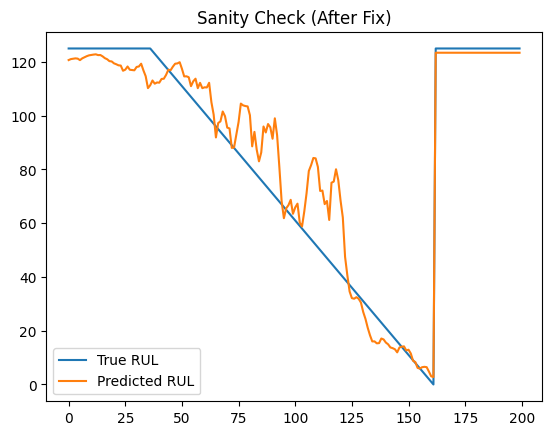

In [19]:
pred = model.predict(X_train[:200])

plt.figure()
plt.plot(y_train[:200], label='True RUL')
plt.plot(pred.flatten(), label='Predicted RUL')
plt.legend()
plt.title("Sanity Check (After Fix)")
plt.show()

In [20]:
print("Final Training MAE:", history.history['mae'][-1])
print("Final Validation MAE:", history.history['val_mae'][-1])
print("Final Training MSE:", history.history['loss'][-1])
print("Final Validation MSE:", history.history['val_loss'][-1])


Final Training MAE: 9.408024787902832
Final Validation MAE: 10.66222858428955
Final Training MSE: 170.7349395751953
Final Validation MSE: 206.2952423095703


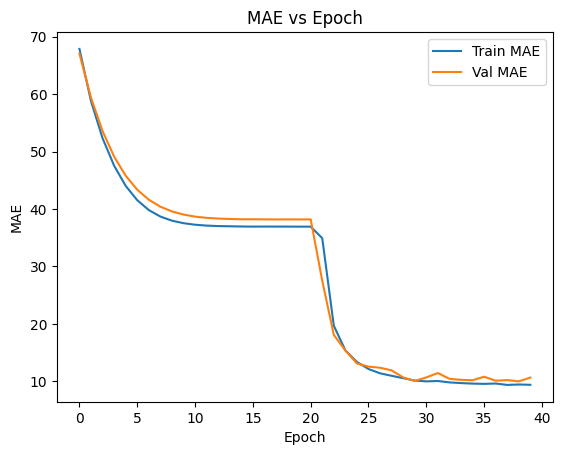

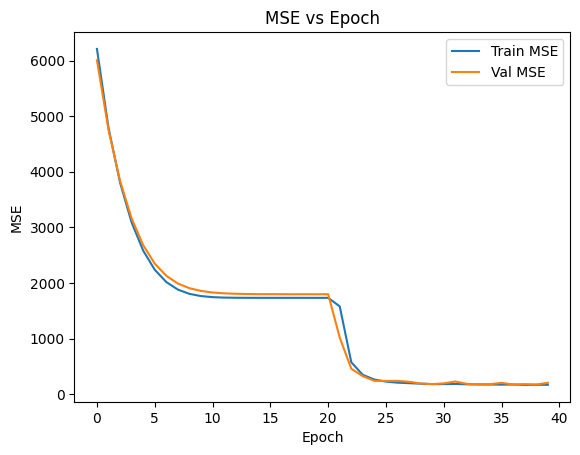

In [21]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE vs Epoch')
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Val MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.title('MSE vs Epoch')
plt.show()
